# Data Science Capstone Project

### This is the Shareable Jupyter Notebook for the Capstone project.

In [1]:
import pandas as pd
import numpy as np
print('Hello Capstone Project Course!')

Hello Capstone Project Course!


## Introduction/Business Problem

The problem at hand is find a solution that can help predict the severity of an accident if an accident were to occur given various environmental information. This is to help potential stakeholders which in this case includes those that have to drive to get to their final destination every day. Given various inputs of a particular day, how can we determine if there will be an accident on the way to a destination? If we can find a method to answer this problem, we can give the stakeholders that insight of choosing a different method of transportation. Not only could this insight potentially offset any risk that the person would incur if they were the ones to get an accident, but it could also allow for their ability to reach their final destination within the time frame that they were expecting to due to not being stuck in traffic waiting for the situation to clear up.


## Data

Using the example dataset’s metadata file, we can see that it is for the relatively high density population within the city of Seattle, Washington. Within this dataset, we can see that it has 37 attributes that can be of interest, including ones that detail the weather, location and level of accidents, the road conditions, among many others. Since we are trying to determine the probability of an accident occurring, and how bad or severe of an accident it will be, we will use the severity attribute as the target variable within our model. In order to decide which attributes would be of most use or importance for the model building, I will apply a feature selection process by utilizing attributes that provide the most information gain on the data, given the target variable. In addition, this dataset also contains an abundance of over 70,000 samples or observations that we can use to train a machine learning model and test against. Since we’ll be working with classification, some classification models that come to mind that may be of use include building a Decision Tree, using K-Nearest Neighbors, Support Vector Machines, and/or Logistic Regression. Once I’ve built each model, I will do a model evaluation based on a couple of scoring mechanism such as the Jaccard Score, Average F1-Score, and LogLoss metrics to see which model performed the best. 

## Methodlogy/Data Exploration

In [2]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
#!conda install -c anaconda seaborn -y
import seaborn as sns
%matplotlib inline

In [3]:
dc = pd.read_csv(r'Data-Collisions.csv')
#Checking Null Values
(dc["ROADCOND"].isnull()==True).sum()
dc.head()

/home/fperez/anaconda3/envs/py37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0.0,0.0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0.0,0.0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0.0,0.0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0.0,0.0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0.0,0.0,N


In [4]:
dc.dtypes
set(dc['SEVERITYCODE'].values)

{1, 2}

In [5]:
Features = ['SEVERITYCODE', 'OBJECTID', 'INCDTTM', 'WEATHER','ROADCOND','LIGHTCOND','SPEEDING']
df = dc[Features]


Removing accidents where there is missing times decreased the number of total observations significantly. May need to add it back and just remove using the date and time.

Want to use SeverityCode 0 to remove unknown records, speeding to remove accidents caused by speeding since its not an environemntal cause, Remove observations with missing data on Road Conditions, Light Condtions, and weather conditions.

In [6]:
df['INCDTTM'] = pd.to_datetime(df['INCDTTM'])

#Removing Null Times/Separating Date&Time Column into 2.
##print(df.shape)
##dtna_con = (df['INCDTTM'].isnull()==True)
##df = df.loc[~(dtna_con),:]
##print(df.shape)

#Removing Timestamps (?)
#timena_con =(df['INCDTTM'].apply(lambda x: str(x.time())!= "00:00:00"))
#df = df.loc[timena_con,:]

##df['Date'],df['Time'] = df['INCDTTM'].apply(lambda x:x.date()),df['INCDTTM'].apply(lambda x:x.time())

##df.drop('INCDTTM', axis=1, inplace=True)
##print(df.shape)

#Now removing accidents caused by speeding specifically
spd_con = (df['SPEEDING'].apply(lambda x:x=='Y'))
df = df.loc[(~spd_con),:]
df.drop('SPEEDING', axis=1, inplace=True)
print(df.shape)

#Removing samples wth no weather data
weather_con = (df['WEATHER'].apply(lambda x: pd.isnull(x)==True\
                    #or x=='Unknown'\
                    or x=='Other')\
                    )

df = df.loc[(~weather_con),:]
print(df.shape)

#Removing samples wth no Road Condition data
road_con = (df['ROADCOND'].apply(lambda x: pd.isnull(x)==True\
                    #or x=='Unknown'\
                    or x=='Other')\
                    )

df = df.loc[(~road_con),:]
print(df.shape)

#Removing samples wth no Lighting Condition data
light_con = (df['LIGHTCOND'].apply(lambda x: pd.isnull(x)==True\
                    #or x=='Unknown'\
                    or x=='Other')\
                    )

df = df.loc[~(light_con),:]
print(df.shape)

/home/fperez/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


(67591, 6)
(67018, 6)
(66972, 6)
(66893, 6)


In [7]:
# Checking the current SeverityCodes in the dataset
#print(set(df['SEVERITYCODE'].values))
#road_con = (df['LIGHTCOND'].apply(lambda x: pd.isnull(x)==True\
#                    or x=='Unknown'\
#                    or x=='Other')\
#                    )
#road_con.sum()

#(df['SPEEDING'].apply(lambda x:np.isnan(x)))

In [8]:
#finding which months have the most accidents
##df['Month'] = pd.to_datetime(df['Date']).dt.month.values
##df['Month'].head()
##df['Dayofweek'] = pd.to_datetime(df['Date']).dt.dayofweek
df.head()

#bins = np.linspace(df.Dayofweek.min(), df.Dayofweek.max(), 10)
#g = sns.FacetGrid(df, col="Month", hue="SEVERITYCODE", palette="Set1", col_wrap=2)
#g.map(plt.hist, 'Dayofweek', bins=bins, ec="k")
#g.axes[-1].legend()
#plt.show()

,SEVERITYCODE,OBJECTID,INCDTTM,WEATHER,ROADCOND,LIGHTCOND
0,2,1,2013-03-27 14:54:00,Overcast,Wet,Daylight
1,1,2,2006-12-20 18:55:00,Raining,Wet,Dark - Street Lights On
2,1,3,2004-11-18 10:20:00,Overcast,Dry,Daylight
3,1,4,2013-03-29 09:26:00,Clear,Dry,Daylight
4,2,5,2004-01-28 08:04:00,Raining,Wet,Daylight


In [9]:
Feature2 = pd.concat([# \df[["Month"]],\
                     pd.get_dummies(df['WEATHER']),\
                     pd.get_dummies(df['ROADCOND']),\
                     pd.get_dummies(df['LIGHTCOND'])],\
                     axis=1)
X = Feature2
print(X.shape)
X.head()

(66893, 25)


,Blowing Sand/Dirt,Clear,Fog/Smog/Smoke,Overcast,Raining,Severe Crosswind,Sleet/Hail/Freezing Rain,Snowing,Unknown,Dry,...,Unknown,Wet,Dark - No Street Lights,Dark - Street Lights Off,Dark - Street Lights On,Dark - Unknown Lighting,Dawn,Daylight,Dusk,Unknown
0,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0


In [10]:
y = df['SEVERITYCODE'].values
y[0:5]

array([2, 1, 1, 1, 2])

## Normalizing Data

In [11]:
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[-0.01813813, -1.22212451, -0.04896544,  2.35050488, -0.44398861,
        -0.01222763, -0.0262324 , -0.06987293, -0.28410339, -1.46380655,
        -0.08375691, -0.01933574, -0.02255067, -0.07736545, -0.0222164 ,
        -0.26919742,  1.79758836, -0.09146718, -0.08090419, -0.57838023,
        -0.00386645, -0.1134478 ,  0.77161353, -0.18754964, -0.25492865],
       [-0.01813813, -1.22212451, -0.04896544, -0.42544051,  2.25231006,
        -0.01222763, -0.0262324 , -0.06987293, -0.28410339, -1.46380655,
        -0.08375691, -0.01933574, -0.02255067, -0.07736545, -0.0222164 ,
        -0.26919742,  1.79758836, -0.09146718, -0.08090419,  1.72896643,
        -0.00386645, -0.1134478 , -1.29598557, -0.18754964, -0.25492865],
       [-0.01813813, -1.22212451, -0.04896544,  2.35050488, -0.44398861,
        -0.01222763, -0.0262324 , -0.06987293, -0.28410339,  0.68315038,
        -0.08375691, -0.01933574, -0.02255067, -0.07736545, -0.0222164 ,
        -0.26919742, -0.55630089, -0.09146718, -0

## Classification: Model Explorations

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),\
                 horizontalalignment="center",\
                 verticalalignment="bottom",\
                 fontsize = 16,\
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15,\
                                                    stratify=y, random_state=2)

print('Training set: ', X_train.shape, y_train.shape)
print('Testing set: ', X_test.shape, y_test.shape)

print("\nDue to unbalanced dataset, we'll be using Stratified training and test sets:\n")
print("Proportion of Severity Level 1 in Training set is %.2f and \n"\
      % ((y_train==1).sum()/y_train.shape[0]) +\
     "Proportion of Severity Level 2 in Training set is %.2f.\n"\
      % ((y_train==2).sum()/y_train.shape[0]) )

print("Proportion of Severity Level 1 in Testing set is %.2f and \n"\
      % ((y_test==1).sum()/y_test.shape[0]) +\
     "Proportion of Severity Level 2 in Testing set is %.2f.\n"\
      % ((y_test==2).sum()/y_test.shape[0]) )

Training set:  (56859, 25) (56859,)
Testing set:  (10034, 25) (10034,)

Due to unbalanced dataset, we'll be using Stratified training and test sets:

Proportion of Severity Level 1 in Training set is 0.71 and 
Proportion of Severity Level 2 in Training set is 0.29.

Proportion of Severity Level 1 in Testing set is 0.71 and 
Proportion of Severity Level 2 in Testing set is 0.29.



### In addition, I will also be attempting oversampling for the minority dataset to see if I can improve the model further.


In [14]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = ros.fit_resample(X_train, y_train)
X_over.shape

(81296, 25)

### K-Nearest Neighbor (KNN)

[0.48365557 0.64899342 0.62198525 0.64630257 0.64411003 0.64670122
 0.64411003 0.64680088 0.63663544]


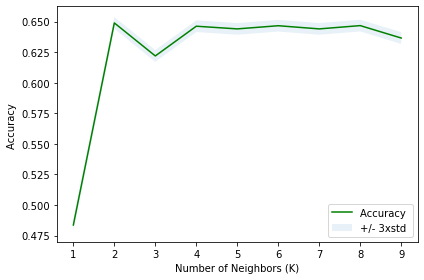

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

Ks=10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat = neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
print(mean_acc)

plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [16]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

n = mean_acc.argmax()+1
neighn = KNeighborsClassifier(n_neighbors=n).fit(X_train, y_train)
yhat_knn = neighn.predict(X_test)
yhat[0:10]

The best accuracy was with 0.6489934223639625 with k= 2


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 2])

              precision    recall  f1-score   support

           1       0.71      0.86      0.78      7173
           2       0.25      0.12      0.16      2861

    accuracy                           0.65     10034
   macro avg       0.48      0.49      0.47     10034
weighted avg       0.58      0.65      0.60     10034

Confusion matrix, without normalization
[[6175  998]
 [2524  337]]


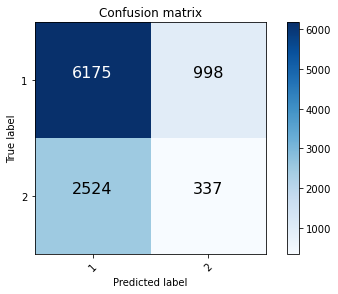

In [17]:
knn_mat = confusion_matrix(y_test, yhat_knn, labels=[1,2])

np.set_printoptions(precision=2)

print(classification_report(y_test, yhat_knn))

plt.figure()
plot_confusion_matrix(knn_mat, classes=[1,2], normalize= False,  title='Confusion matrix')


### KNN with Oversampling of Minority Class (SEVERITYCODE=2)

[0.67 0.69 0.61 0.65 0.47 0.71 0.71 0.71 0.69]


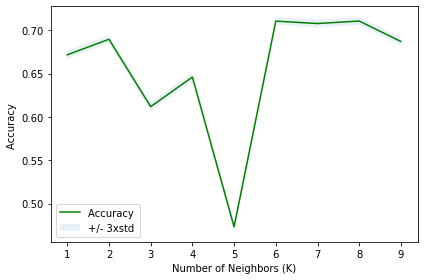

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

Ks=10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_over,y_over)
    yhat = neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
print(mean_acc)

plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [19]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

n = mean_acc.argmax()+1
neighnOver = KNeighborsClassifier(n_neighbors=n).fit(X_over, y_over)
yhat_knnOver = neighnOver.predict(X_test)
yhat_knnOver[0:10]

The best accuracy was with 0.7105840143512059 with k= 8


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

              precision    recall  f1-score   support

           1       0.72      0.99      0.83      7173
           2       0.31      0.01      0.02      2861

    accuracy                           0.71     10034
   macro avg       0.51      0.50      0.43     10034
weighted avg       0.60      0.71      0.60     10034

Confusion matrix, without normalization
[[7096   77]
 [2827   34]]


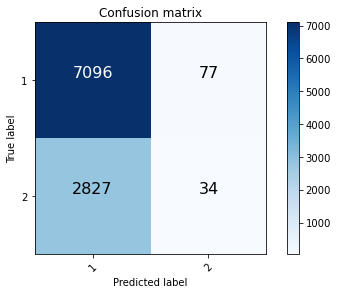

In [20]:
knn_matOver = confusion_matrix(y_test, yhat_knnOver, labels=[1,2])

np.set_printoptions(precision=2)

print(classification_report(y_test, yhat_knnOver))

plt.figure()
plot_confusion_matrix(knn_matOver, classes=[1,2], normalize= False,  title='Confusion matrix')


## Decision Tree Modeling

[0.71 0.71 0.71 0.71 0.71 0.71 0.71 0.71 0.71 0.71 0.71 0.71 0.71 0.71
 0.71 0.71 0.71 0.71 0.71 0.71 0.71 0.71 0.71 0.71 0.71 0.71 0.71 0.71
 0.71 0.71 0.71 0.71 0.71 0.71 0.71 0.71 0.71 0.71 0.71 0.71 0.71 0.71
 0.71 0.71 0.71 0.71 0.71 0.71 0.71]


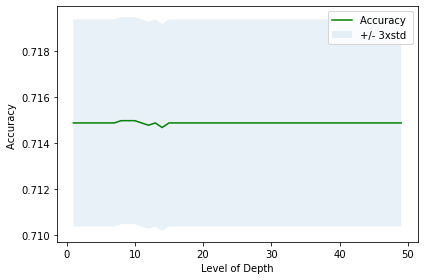

In [21]:
from sklearn.tree import DecisionTreeClassifier

Dps=50
mean_acc_dp = np.zeros((Dps-1))
std_acc_dp = np.zeros((Dps-1))

for n in range(1,Dps):
    accTree = DecisionTreeClassifier(criterion='entropy', max_depth=n).fit(X_train, y_train)
    yhat_dp = accTree.predict(X_test)
    mean_acc_dp[n-1] = metrics.accuracy_score(y_test, yhat_dp)
    std_acc_dp[n-1]=np.std(yhat_dp==y_test)/np.sqrt(yhat_dp.shape[0])
    
print(mean_acc_dp)

plt.plot(range(1,Dps),mean_acc_dp,'g')
plt.fill_between(range(1,Dps), mean_acc_dp - 1 * std_acc_dp, mean_acc_dp + 1 * std_acc_dp, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Level of Depth')
plt.tight_layout()
plt.show()

In [22]:
print( "The best accuracy was with", mean_acc_dp.max(), "with Depth=", mean_acc_dp.argmax()+1) 
n = 8
DT1 = DecisionTreeClassifier(criterion='entropy', max_depth=n).fit(X_train, y_train)
yhat_dt = DT1.predict(X_test)
yhat_dt[0:10]

The best accuracy was with 0.7149691050428543 with Depth= 8


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

              precision    recall  f1-score   support

           1       0.72      1.00      0.83      7173
           2       0.60      0.00      0.00      2861

    accuracy                           0.71     10034
   macro avg       0.66      0.50      0.42     10034
weighted avg       0.68      0.71      0.60     10034

Confusion matrix, without normalization
[[7171    2]
 [2858    3]]


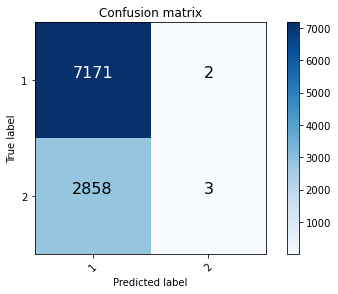

In [23]:
dt_mat = confusion_matrix(y_test, yhat_dt, labels=[1,2])

np.set_printoptions(precision=2)

print(classification_report(y_test, yhat_dt))

plt.figure()
plot_confusion_matrix(dt_mat, classes=[1,2], normalize= False,  title='Confusion matrix')

### Decision Tree with Oversampling of Minority Class

[0.34 0.35 0.49 0.46 0.46 0.47 0.47 0.45 0.45 0.45 0.45 0.46 0.46 0.46
 0.45 0.45 0.45 0.45 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46
 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46
 0.46 0.46 0.46 0.46 0.46 0.46 0.46]


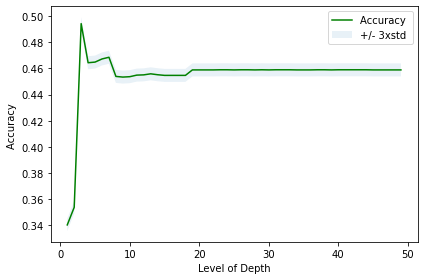

In [24]:
Dps=50
mean_acc_dp = np.zeros((Dps-1))
std_acc_dp = np.zeros((Dps-1))

for n in range(1,Dps):
    accTree = DecisionTreeClassifier(criterion='entropy', max_depth=n).fit(X_over, y_over)
    yhat_dp = accTree.predict(X_test)
    mean_acc_dp[n-1] = metrics.accuracy_score(y_test, yhat_dp)
    std_acc_dp[n-1]=np.std(yhat_dp==y_test)/np.sqrt(yhat_dp.shape[0])
    
print(mean_acc_dp)

plt.plot(range(1,Dps),mean_acc_dp,'g')
plt.fill_between(range(1,Dps), mean_acc_dp - 1 * std_acc_dp, mean_acc_dp + 1 * std_acc_dp, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Level of Depth')
plt.tight_layout()
plt.show()

In [25]:
print( "The best accuracy using OVERSAMPLING was", mean_acc_dp.max(), "with Depth=", mean_acc_dp.argmax()+1) 
n = mean_acc_dp.argmax()+1
DT1Over = DecisionTreeClassifier(criterion='entropy', max_depth=n).fit(X_over, y_over)
yhat_dtOver = DT1Over.predict(X_test)
yhat_dtOver[0:10]

The best accuracy using OVERSAMPLING was 0.49421965317919075 with Depth= 3


array([2, 2, 2, 2, 2, 1, 2, 2, 2, 1])

              precision    recall  f1-score   support

           1       0.77      0.42      0.54      7173
           2       0.32      0.69      0.44      2861

    accuracy                           0.49     10034
   macro avg       0.54      0.55      0.49     10034
weighted avg       0.64      0.49      0.51     10034

Confusion matrix, without normalization
[[2996 4177]
 [ 898 1963]]


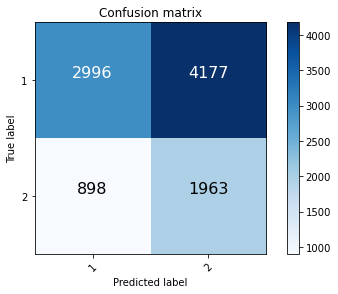

In [26]:
dt_matOver = confusion_matrix(y_test, yhat_dtOver, labels=[1,2])

np.set_printoptions(precision=2)

print(classification_report(y_test, yhat_dtOver))

plt.figure()
plot_confusion_matrix(dt_matOver, classes=[1,2], normalize= False,  title='Confusion matrix')

## Support Vector Machines

In [27]:
from sklearn import svm

SVM_acc = svm.SVC(kernel='rbf')
SVM_acc.fit(X_train, y_train)
yhat_svm = SVM_acc.predict(X_test)
yhat_svm[0:10]


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

              precision    recall  f1-score   support

           1       0.71      1.00      0.83      7173
           2       0.50      0.00      0.00      2861

    accuracy                           0.71     10034
   macro avg       0.61      0.50      0.42     10034
weighted avg       0.65      0.71      0.60     10034

Confusion matrix, without normalization
[[7171    2]
 [2859    2]]


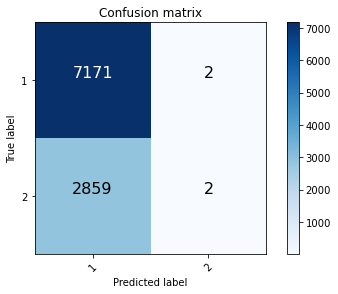

In [28]:
svm_mat = confusion_matrix(y_test, yhat_svm, labels=[1,2])

np.set_printoptions(precision=2)

print(classification_report(y_test, yhat_svm))

plt.figure()
plot_confusion_matrix(svm_mat, classes=[1,2], normalize= False,  title='Confusion matrix')

### Support Vector Machine with Oversampling Minority Class

In [29]:
SVM_accOver = svm.SVC(kernel='rbf')
SVM_accOver.fit(X_over, y_over)
yhat_svmOver = SVM_accOver.predict(X_test)
yhat_svmOver[0:10]


array([2, 2, 2, 2, 1, 2, 2, 2, 2, 1])

              precision    recall  f1-score   support

           1       0.80      0.33      0.46      7173
           2       0.32      0.79      0.45      2861

    accuracy                           0.46     10034
   macro avg       0.56      0.56      0.46     10034
weighted avg       0.66      0.46      0.46     10034

Confusion matrix, without normalization
[[2354 4819]
 [ 605 2256]]


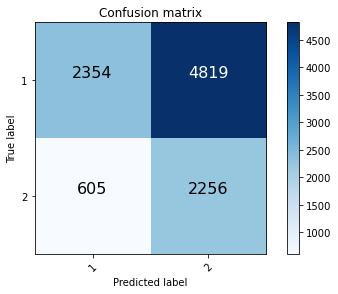

In [30]:
svm_matOver = confusion_matrix(y_test, yhat_svmOver, labels=[1,2])

np.set_printoptions(precision=2)

print(classification_report(y_test, yhat_svmOver))

plt.figure()
plot_confusion_matrix(svm_matOver, classes=[1,2], normalize= False,  title='Confusion matrix')

## Logistic Regression

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train, y_train)

In [32]:
yhat_lr = LR.predict(X_test)
yhat_pb_lr = LR.predict_proba(X_test)
yhat_lr[0:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

/home/fperez/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.71      1.00      0.83      7173
           2       0.00      0.00      0.00      2861

    accuracy                           0.71     10034
   macro avg       0.36      0.50      0.42     10034
weighted avg       0.51      0.71      0.60     10034

Confusion matrix, without normalization
[[7173    0]
 [2861    0]]


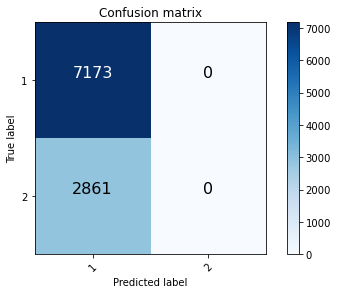

In [33]:
lr_mat = confusion_matrix(y_test, yhat_lr, labels=[1,2])

np.set_printoptions(precision=2)

print(classification_report(y_test, yhat_lr))

plt.figure()
plot_confusion_matrix(lr_mat, classes=[1,2], normalize= False,  title='Confusion matrix')

### Logistic Regression with Oversampling the Minority Class

In [34]:
LROver = LogisticRegression(C=0.01, solver='liblinear').fit(X_over, y_over)
yhat_lrOver = LROver.predict(X_test)
yhat_pb_lrOver = LROver.predict_proba(X_test)
yhat_lrOver[0:10]

array([2, 2, 2, 2, 1, 2, 2, 2, 2, 1])

              precision    recall  f1-score   support

           1       0.80      0.32      0.45      7173
           2       0.32      0.80      0.45      2861

    accuracy                           0.45     10034
   macro avg       0.56      0.56      0.45     10034
weighted avg       0.66      0.45      0.45     10034

Confusion matrix, without normalization
[[2278 4895]
 [ 586 2275]]


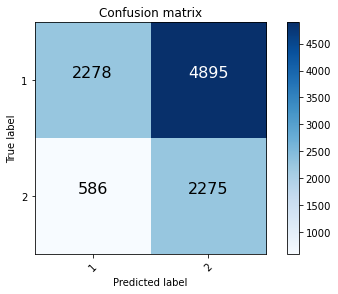

In [35]:
lr_matOver = confusion_matrix(y_test, yhat_lrOver, labels=[1,2])

np.set_printoptions(precision=2)

print(classification_report(y_test, yhat_lrOver))

plt.figure()
plot_confusion_matrix(lr_matOver, classes=[1,2], normalize= False,  title='Confusion matrix')

# Model Evaluations

In [36]:
from sklearn.metrics import jaccard_score
#from sklearn.metrics import jaccard_similarity_score # Now Deprecated
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

## KNN Jaccard and F1-Score Evaluations

In [37]:
jaccard_score(y_test, yhat_knn)
print("KNN Jaccard score: %.4f" % jaccard_score(y_test, yhat_knn))
f1_score(y_test, yhat_knn, average='weighted')
print("KNN Avg F1-score: %.4f" % f1_score(y_test, yhat_knn, average='weighted'))

KNN Jaccard score: 0.6368
KNN Avg F1-score: 0.6020


### KNN Oversampling Evaluations

In [38]:
jaccard_score(y_test, yhat_knnOver)
print("KNN (Oversampling) Jaccard score: %.4f" % jaccard_score(y_test, yhat_knnOver))
f1_score(y_test, yhat_knnOver, average='weighted')
print("KNN (Oversampling) Avg F1-score: %.4f" % f1_score(y_test, yhat_knnOver, average='weighted'))

KNN (Oversampling) Jaccard score: 0.7096
KNN (Oversampling) Avg F1-score: 0.6000


## Decision Tree Jaccard and F1-Score Evaluations

In [39]:
jaccard_score(y_test, yhat_dt)
print("Decision Tree Jaccard score: %.4f" % jaccard_score(y_test, yhat_dt))
f1_score(y_test, yhat_dt, average='weighted')
print("Decision Tree Avg F1-score: %.4f" % f1_score(y_test, yhat_dt, average='weighted'))

Decision Tree Jaccard score: 0.7149
Decision Tree Avg F1-score: 0.5966


### Decision Tree Oversampling Evaluations

In [40]:
jaccard_score(y_test, yhat_dtOver)
print("Decision Tree (Oversampling) Jaccard score: %.4f" % jaccard_score(y_test, yhat_dtOver))
f1_score(y_test, yhat_dtOver, average='weighted')
print("Decision Tree (Oversampling) Avg F1-score: %.4f" % f1_score(y_test, yhat_dtOver, average='weighted'))

Decision Tree (Oversampling) Jaccard score: 0.3712
Decision Tree (Oversampling) Avg F1-score: 0.5114


## SVM Jaccard and F1-Score Evaluations

In [41]:
jaccard_score(y_test, yhat_svm)
print("SVM Jaccard score: %.4f" % jaccard_score(y_test, yhat_svm))
f1_score(y_test, yhat_svm, average='weighted')
print("SVM Avg F1-score: %.4f" % f1_score(y_test, yhat_svm, average='weighted'))

SVM Jaccard score: 0.7148
SVM Avg F1-score: 0.5964


### SVM Oversampling Evaluations

In [42]:
jaccard_score(y_test, yhat_svmOver)
print("SVM Oversampling Jaccard score: %.4f" % jaccard_score(y_test, yhat_svmOver))
f1_score(y_test, yhat_svmOver, average='weighted')
print("SVM Oversampling Avg F1-score: %.4f" % f1_score(y_test, yhat_svmOver, average='weighted'))

SVM Oversampling Jaccard score: 0.3026
SVM Oversampling Avg F1-score: 0.4617


## Logistic Regression Jaccard, F1-Score, and LogLoss Evaluations

In [43]:
jaccard_score(y_test, yhat_lr)
print("Logistic Regression Jaccard score: %.4f" % jaccard_score(y_test, yhat_lr))
f1_score(y_test, yhat_lr, average='weighted')
print("Logistic Regression Avg F1-score: %.4f" % f1_score(y_test, yhat_lr, average='weighted'))
yhat_Testprob = LR.predict_proba(X_test)
#yhat_Testprob
log_loss(y_test, yhat_Testprob)
print("Logistic Regression LogLoss: %.2f" % log_loss(y_test, yhat_Testprob))

Logistic Regression Jaccard score: 0.7149
Logistic Regression Avg F1-score: 0.5960
Logistic Regression LogLoss: 0.58


In [44]:
jaccard_score(y_test, yhat_lrOver)
print("Logistic Regression Jaccard score: %.4f" % jaccard_score(y_test, yhat_lrOver))
f1_score(y_test, yhat_lrOver, average='weighted')
print("Logistic Regression Avg F1-score: %.4f" % f1_score(y_test, yhat_lrOver, average='weighted'))
yhat_TestprobOver = LROver.predict_proba(X_test)
#yhat_Testprob
log_loss(y_test, yhat_TestprobOver)
print("Logistic Regression LogLoss: %.2f" % log_loss(y_test, yhat_TestprobOver))

Logistic Regression Jaccard score: 0.2936
Logistic Regression Avg F1-score: 0.4538
Logistic Regression LogLoss: 0.68
